# [#defi_carto] - Sapins Noël 2024 🌲

## 1 - Import des modules

In [1]:
import os
import numpy as np
from PIL import Image
from io import BytesIO
import geopandas as gpd
import matplotlib as mpl
import contextily as ctx
import matplotlib.pyplot as plt
from svgpath2mpl import parse_path
from svgpathtools import svg2paths
from highlight_text import fig_text, ax_text
from shapely.geometry import Point, shape, Polygon, LineString

## 2 - Import des données

### 2.1 - Mes données enrichis

In [2]:
data = gpd.read_parquet("Documents/geoDataScience/defi_carto_sapin_2024/data/christmas_tree.parquet")
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   dep-code-txt                   96 non-null     object  
 1   dep-nom                        96 non-null     object  
 2   sapin-nb-exploitation          96 non-null     float64 
 3   sapin-nb-hectare               96 non-null     float64 
 4   total-nb-expl                  96 non-null     int32   
 5   total-nb-ha                    96 non-null     float64 
 6   region_name                    96 non-null     object  
 7   sapin-nb-exploitation-is-null  96 non-null     bool    
 8   sapin-nb-hectare-is-null       96 non-null     bool    
 9   total-nb-ha-is-null            96 non-null     bool    
 10  geometry                       96 non-null     geometry
 11  centroid_point                 96 non-null     geometry
dtypes: bool(3), float64(3), geomet

### 2.2 - Données contours europe

In [3]:
contour_europe = gpd.read_file("https://raw.githubusercontent.com/leakyMirror/map-of-europe/refs/heads/master/GeoJSON/europe.geojson")
contour_europe.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   FID        51 non-null     float64 
 1   FIPS       51 non-null     object  
 2   ISO2       51 non-null     object  
 3   ISO3       51 non-null     object  
 4   UN         51 non-null     int32   
 5   NAME       51 non-null     object  
 6   AREA       51 non-null     int32   
 7   POP2005    51 non-null     int32   
 8   REGION     51 non-null     int32   
 9   SUBREGION  51 non-null     int32   
 10  LON        51 non-null     float64 
 11  LAT        51 non-null     float64 
 12  geometry   51 non-null     geometry
dtypes: float64(3), geometry(1), int32(5), object(4)
memory usage: 4.3+ KB


## 3 - Création de la carte

### 3.1 - Import des assets
> Pictos, Fonts

In [4]:
# Fonction couleur ++
background_color = '#edf2f4'
text_color = '#14213d'
map_color = 'white'

assets_folder = "Documents/geoDataScience/defi_carto_sapin_2024/assets"
file_names = os.listdir("Documents/geoDataScience/defi_carto_sapin_2024/assets")
markers = {}

for file_name in file_names:
    if file_name.endswith(".svg"):
        file_path = os.path.join(assets_folder, file_name)
        path, attributes = svg2paths(file_path)
        
        marker = parse_path(attributes[0]["d"])
        marker.vertices -= marker.vertices.mean(axis=0)
        marker = marker.transformed(mpl.transforms.Affine2D().rotate_deg(180))
        marker = marker.transformed(mpl.transforms.Affine2D().scale(-1, 1))
        
        markers[file_name] = marker

In [5]:
# Open an image from a computer 
def open_image_local(path_to_image):
    image = Image.open(path_to_image)
    image_array = np.array(image)
    return image_array

### 3.2 - Fonction d'affichages des données ponctuelles

In [6]:
# Fonction d'affichage des données
def plot_points(data_points, size_marker, my_markers, ax):
    data_points["centroid_point"].plot(
        ax=ax,
        markersize=size_marker,
        marker=my_markers,
        color="#4B8958"
    )

In [7]:
# Fonction affichage de la légende
def plot_legend(data_points, size_marker, my_markers, ax):
    centroid_point = data_points["centroid_point"].iloc[0]
    point = data_points["centroid_point"]
    x, y = point.x, point.y
    
    ax.scatter(
        x-8.3, y-5.1, 
        s=size_marker, 
        marker=my_markers, 
        color="#4B8958"
    )

In [8]:
# Fonction pour afficher les annotations sur la carte
def plot_annotations(data_points, position_x, position_y_1, position_y_2, text_justify):
    point = data_points["centroid_point"].iloc[0]
    x, y = point.x, point.y

    # Nom du département
    ax.annotate(
    f"{data_points["dep-nom"].values[0]}",
    xy=(x, y),
    xytext=(x+position_x, y+position_y_1),
    color="#0F4B29",
    fontsize=12,
    fontweight="bold",
    ha=text_justify,
    va="top",
    )

    # Afficher sapin-nb-hectare
    ax.annotate(
        f"{int(data_points["sapin-nb-hectare"].values[0])} hectares",
        xy=(x, y),
        xytext=(x+position_x, y+position_y_2),
        color='#0F4B29',
        fontsize=12,
        ha=text_justify,
        va="top",
    )

### 3.3 - Affichage de la carte

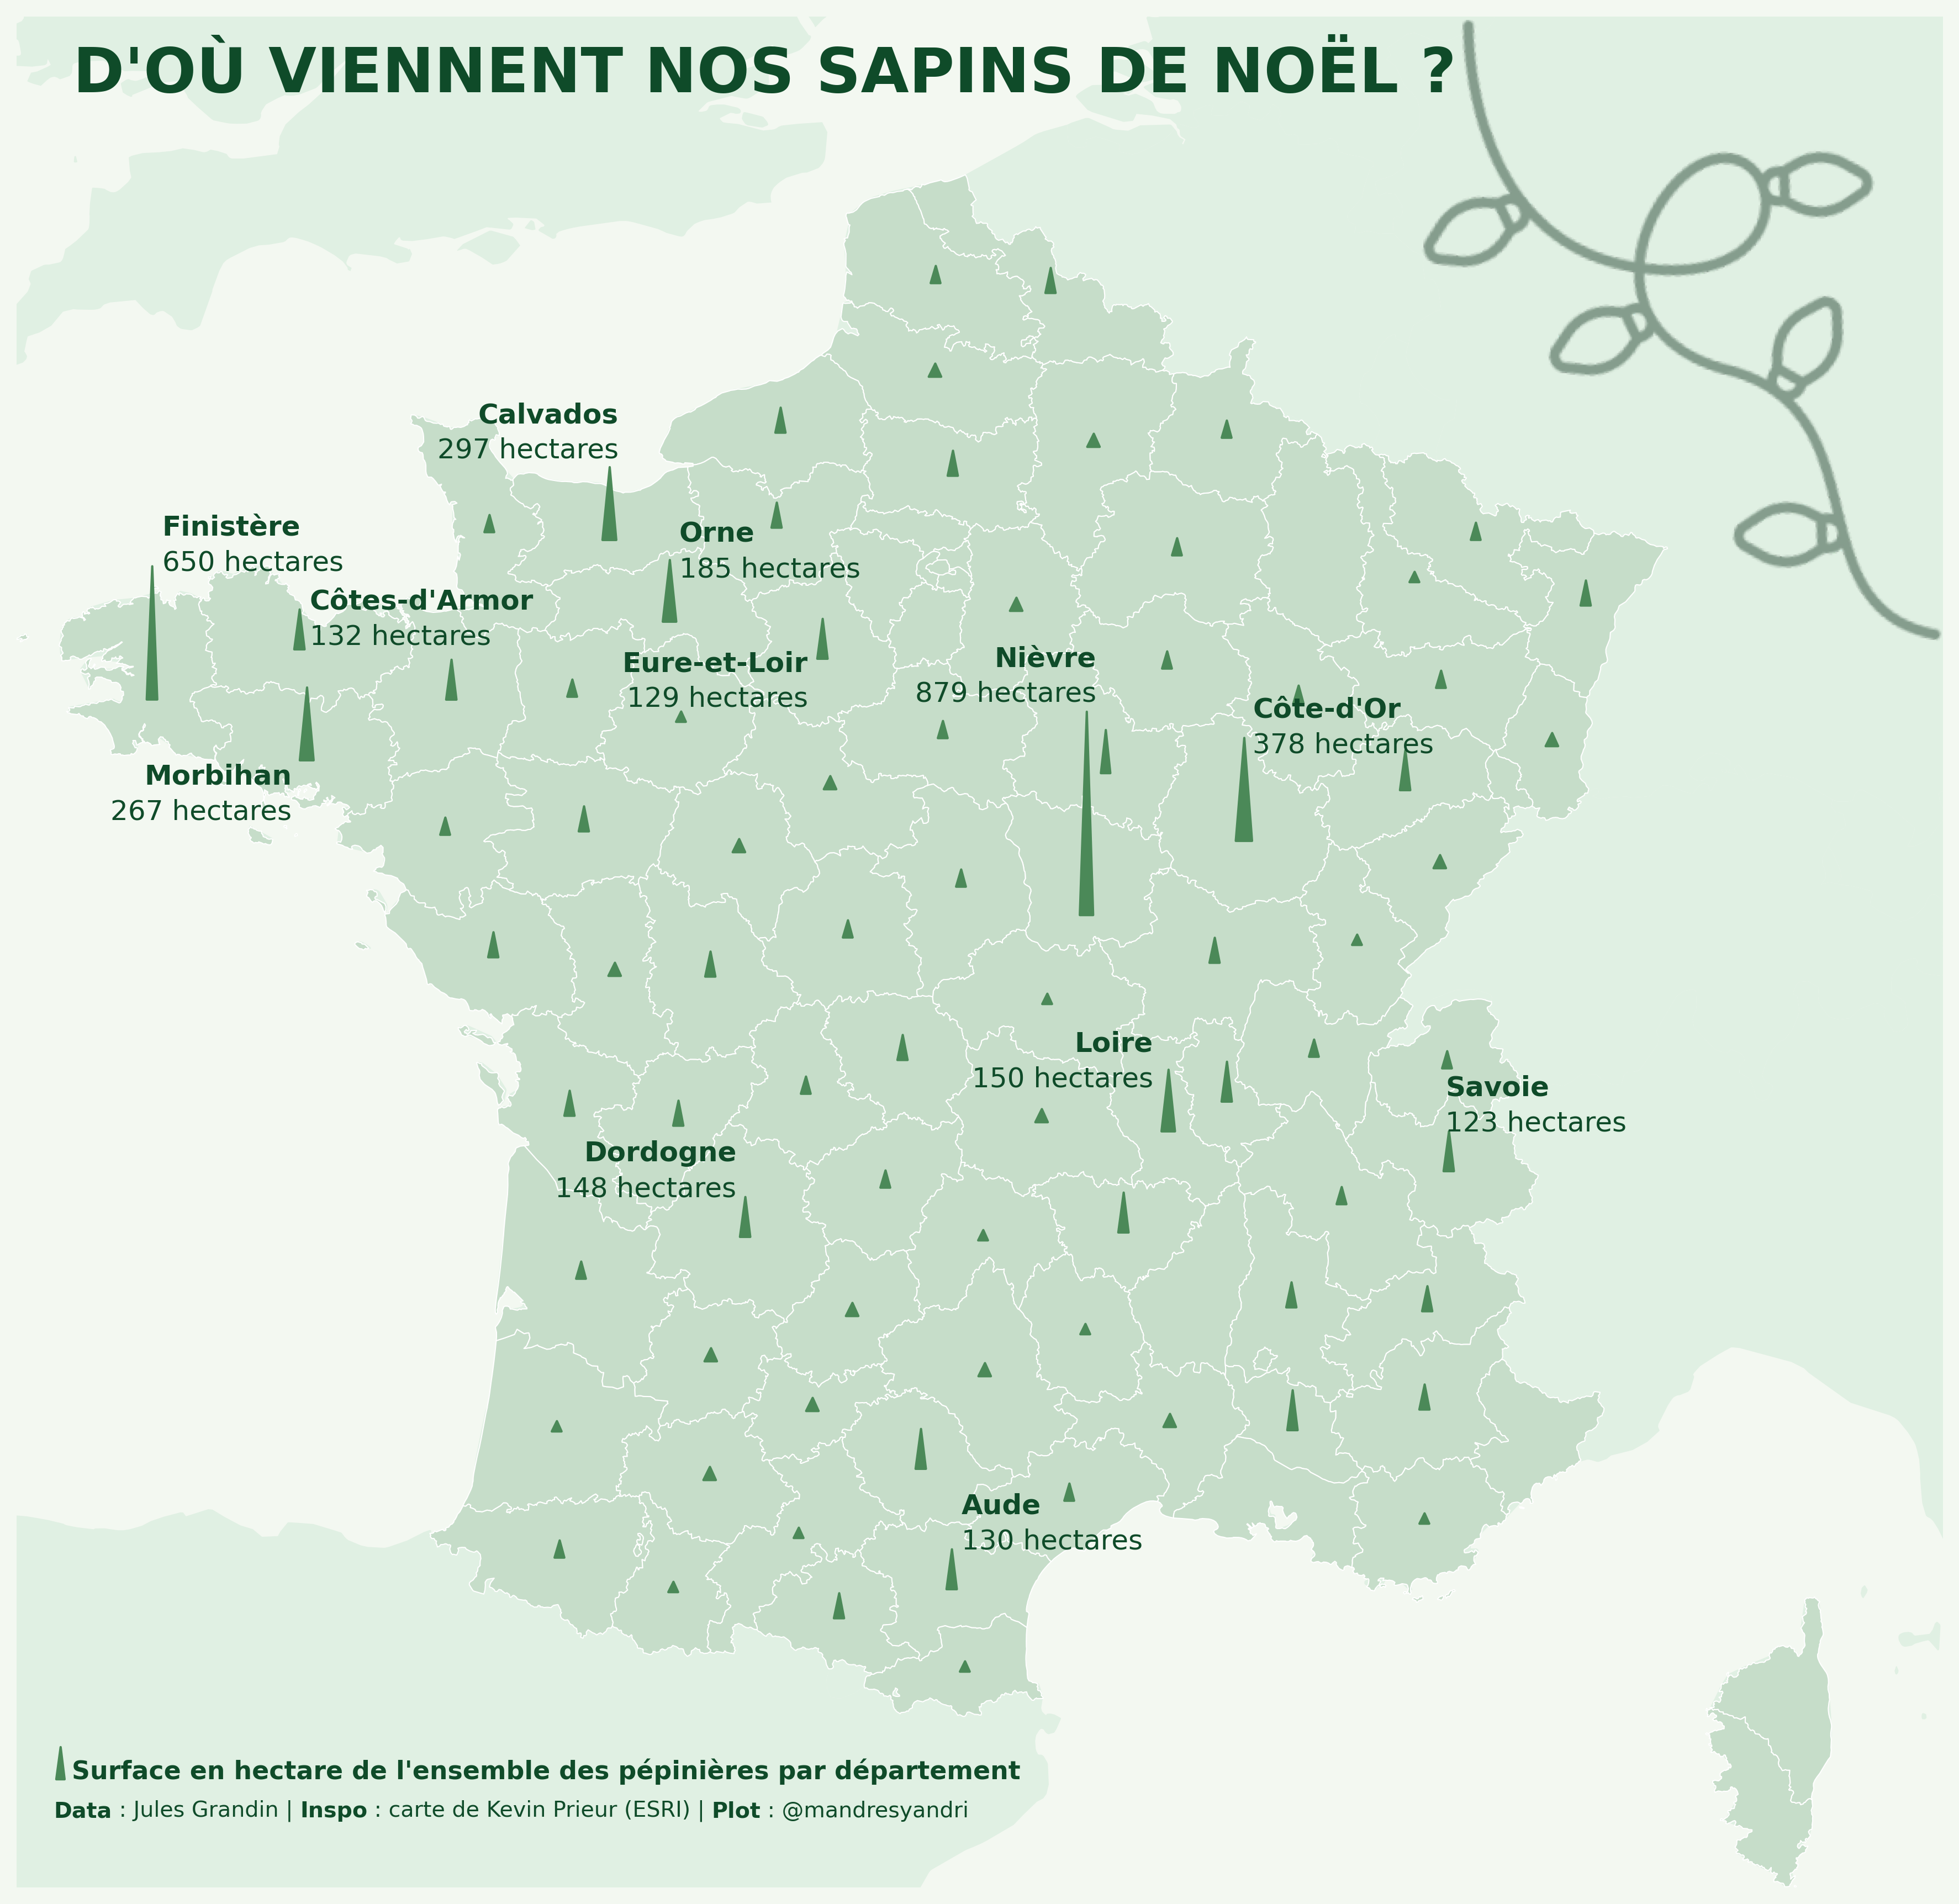

In [9]:
# Création de la figure
fig, ax = plt.subplots(figsize=(10*1.5, 10*1.5), dpi=300)

# Textes de description
fig_text(x=0.4259, y=0.86, s="D'où viennent nos sapins de Noël ?".upper(), color="#0F4B29", fontsize=18 * 1.5, ha='center', va='top', weight="bold")
fig_text(x=0.14, y=0.16, s="  Surface en hectare de l'ensemble des pépinières par département", size=11, color="#0F4B29", ha='left',  va='bottom', weight="bold")
fig_text(
    x=0.14, y=0.145,
    s="<Data> : Jules Grandin | <Inspo> : carte de Kevin Prieur (ESRI) | <Plot> : @mandresyandri",
    size=9.5, color="#0F4B29", ha='left', va='bottom',
    highlight_textprops=[{'fontweight': 'bold'}, {'fontweight': 'bold'}, {'fontweight': 'bold'}]
)

# configuration du graphique
ax.axis('off') # Pour debug la carte
ax.margins(y=0.8)
fig.patch.set_facecolor('#F3F8F1')

# Contour Europe
contour_europe.plot(ax=ax,color="#E0F0E3")

# Contour France
data.plot(color="#C6DDC9",ax=ax,edgecolor="white",linewidth=0.5,alpha=1)

# Couches points
plot_points(data[data["sapin-nb-hectare"] > 800], 20_000.0, markers['marker_800.svg'], ax=ax)
plot_points(data[(data["sapin-nb-hectare"] >= 600) & (data["sapin-nb-hectare"] < 800)], 20_000/2.33, markers['marker_600.svg'], ax=ax)
plot_points(data[(data["sapin-nb-hectare"] >= 300) & (data["sapin-nb-hectare"] < 600)], 20_000/3.9, markers['marker_300.svg'], ax=ax)
plot_points(data[(data["sapin-nb-hectare"] >= 200) & (data["sapin-nb-hectare"] < 300)], 20_000/7.8, markers['marker_200.svg'], ax=ax)
plot_points(data[((data["sapin-nb-hectare"] >= 150) & (data["sapin-nb-hectare"] < 200)) & (data["dep-nom"] != "Yonne")], 20_000/10.88, markers['marker_150.svg'], ax=ax)
plot_points(data[(data["sapin-nb-hectare"] >= 100) & (data["sapin-nb-hectare"] < 150)], 20_000/25.99, markers['marker_100.svg'], ax=ax)
plot_points(data[(data["sapin-nb-hectare"] >= 60) & (data["sapin-nb-hectare"] < 100)], 20_000/65.99, markers['marker_60.svg'], ax=ax)
plot_points(data[(data["sapin-nb-hectare"] >= 30) & (data["sapin-nb-hectare"] < 60)], 20_000/140, markers['marker_30.svg'], ax=ax)
plot_points(data[(data["sapin-nb-hectare"] >= 15) & (data["sapin-nb-hectare"] < 30)], 20_000/240, markers['marker_15.svg'], ax=ax)
plot_points(data[(data["sapin-nb-hectare"] > 0) & (data["sapin-nb-hectare"] < 15)], 20_000/390, markers['marker_15.svg'], ax=ax)
plot_points(data[(data["sapin-nb-hectare"] == 0)], 0, ".", ax=ax)

# Afficher les annotations
plot_annotations(data[data["sapin-nb-hectare"] > 800], 0.1, 1.3, 1.1, "right")
plot_annotations(data[(data["sapin-nb-hectare"] >= 600) & (data["sapin-nb-hectare"] < 800)], 0.1, 0.9, 0.7, "left")
plot_annotations(data[(data["sapin-nb-hectare"] >= 300) & (data["sapin-nb-hectare"] < 600)], 0.1, 0.7, 0.5, "left")
plot_annotations(data[data["dep-nom"] == "Calvados"], 0.1, 0.7, 0.5, "right")
plot_annotations(data[data["dep-nom"] == "Morbihan"], -0.1, -0.1, -0.3, "right")
plot_annotations(data[data["dep-nom"] == "Orne"], +0.1, +0.5, +0.3, "left")
plot_annotations(data[data["dep-nom"] == "Loire"], -0.1, +0.5, +0.3, "right")
plot_annotations(data[data["dep-nom"] == "Côtes-d'Armor"], +0.1, +0.3, +0.1, "left")
plot_annotations(data[data["dep-nom"] == "Eure-et-Loir"], -0.1, -0.0, -0.2, "right")
plot_annotations(data[data["dep-nom"] == "Dordogne"], -0.05, +0.5, +0.3, "right")
plot_annotations(data[data["dep-nom"] == "Savoie"], -0.01, +0.5, +0.3, "left")
plot_annotations(data[data["dep-nom"] == "Aude"], +0.1, +0.5, +0.3, "left")

# Exception ajustement des centroid d'Yonne (chevauchement)
yonne_data = data[data["dep-nom"] == "Yonne"]
x_coords = yonne_data["centroid_point"].apply(lambda point: point.x)
y_coords = yonne_data["centroid_point"].apply(lambda point: point.y)
plt.plot(x_coords+0.1, y_coords-0.1, markersize=30, marker=markers['marker_150.svg'], color="#4B8958")

# Afficher la guirlande de Noël
image = open_image_local('Documents/geoDataScience/defi_carto_sapin_2024/assets/marker_light.png')
ax_image = fig.add_axes([0.66, 0.62, 0.25, 0.25])
ax_image.imshow(image)
ax_image.set_xlim(0, 350)
ax_image.axis('off') # pour debug l'affichage

# Zoomer sur la couche France
minx, miny, maxx, maxy = data.total_bounds 
ax.set_xlim(minx, maxx+0.9)
ax.set_ylim(miny, maxy+0.9)

# Afficher les la légende
plot_legend(data[data["sapin-nb-hectare"] > 800], 500, markers['marker_100.svg'], ax=ax)

plt.show()
fig.savefig("Documents/geoDataScience/defi_carto_sapin_2024/assets/christmas_tree.png", bbox_inches='tight', pad_inches=0, transparent=False)

-- END --